## Step 5: Implementing a Machine Learning algorithm 

### Background: 
Once we have the information from the satellite band pixels and the respective soil moisture values, we can implement a machine learning algorithm that can correlate  the band pixels (we will call this input) and soil moisture (output). There are plenty of machine learning algorithms. A good website where examples and Python implemented algorithms are compiled is https://scikit-learn.org/stable/.

In this case, we are going to use several machine learning algorithms available in google earth engine. Thses algorithms are a good example of a "classical machine learning", different of more recent algorithms such as Deep Learning (e.g. Convolutional Neural Networks). The advantage of classical machine learning is the need of much less information than deep learning algorithms.

Let's install the necessary python library. Open the terminal and pass the following command.

In [1]:
import geemap
import ee
ee.Initialize()

In [2]:
in_shp = './/Results Step 1//soil_moisture.shp'

sm_locations = geemap.shp_to_ee(in_shp)

Map1 = geemap.Map() 
Map1.addLayer(sm_locations, {'color': 'red'}, 'Soil Moisture')

Map1.centerObject(sm_locations, 12)

Map1

Map(center=[39.4037160204789, -112.63575111241983], controls=(WidgetControl(options=['position', 'transparent_…

Let's start importing the csv file generated in Step 2:

In [3]:
print(sm_locations.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-112.65024, 39.38476]}, 'id': '0', 'properties': {'CROP': 'alfalfa', 'FIELD': '101A', 'SA0513': 0.6, 'SA0529': 0.09, 'SA0614': 0, 'SA0630': 0.05, 'SM0513': 0.39, 'SM0529': 0.14, 'SM0614': 0.1, 'SM0630': 0.13, 'T0513': 24.93, 'T0529': 25.8, 'T0614': 23.77, 'T0630': 28.97, 'sampling p': 1}}


In [4]:
def set_SM0513(feature):
    # keepProperties = 'SA0513';
    location=feature.geometry().centroid()
    return ee.Feature(location).set('SM',feature.get('SM0513'))

In [5]:
sm_0513=sm_locations.map(set_SM0513)
print(sm_0513.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-112.65024000000001, 39.38476]}, 'id': '0', 'properties': {'SM': 0.39}}


In [6]:
def set_SM0529(feature):
    # keepProperties = 'SA0513';
    location=feature.geometry().centroid()
    return ee.Feature(location).set('SM',feature.get('SM0529'))

In [7]:
sm_0529=sm_locations.map(set_SM0529)
print(sm_0529.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-112.65024000000001, 39.38476]}, 'id': '0', 'properties': {'SM': 0.14}}


In [8]:
def set_SM0614(feature):
    # keepProperties = 'SA0513';
    location=feature.geometry().centroid()
    return ee.Feature(location).set('SM',feature.get('SM0614'))

In [9]:
sm_0614=sm_locations.map(set_SM0614)
print(sm_0614.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-112.65024000000001, 39.38476]}, 'id': '0', 'properties': {'SM': 0.1}}


In [10]:
def set_SM0630(feature):
    # keepProperties = 'SA0513';
    location=feature.geometry().centroid()
    return ee.Feature(location).set('SM',feature.get('SM0630'))

In [11]:
sm_0630=sm_locations.map(set_SM0630)
print(sm_0630.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-112.65024000000001, 39.38476]}, 'id': '0', 'properties': {'SM': 0.13}}


Now we have four feature collections that have soil moisture information only and now we need to retrieve the pixel values from the four different images.

In [12]:
import eemont

import warnings #the last command produces a lot of warnings
warnings.filterwarnings('ignore')

# identifying landsat 7 image on the dates of interest


Delta_area=ee.Geometry.Point([-112.577170, 39.352178])

# Let's use the bands and vegetation indices that are not correlated with others (Step 3)
predictionBands=['SR_B1', 'SR_B4', 'SR_B5', 'ST_B6', 'AFRI1600', 'BCC', 'CVI', 'DSWI2', 'DSWI3',
 'DSWI4', 'ExG', 'IKAW', 'NDDI', 'NDYI', 'NMDI', 'NRFIg', 'NRFIr']

landsat7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2").filterBounds(Delta_area) # Landsat 7 archive.
landsat7 = landsat7.preprocess()
landsat7 = landsat7.spectralIndices('vegetation')
landsat7 = landsat7.select(predictionBands);

let's identify the images for the analysis

In [13]:
# code for the first Landsat date
landsat7_may_13 = ee.Image(landsat7. #the dataset
                    filterDate('2012-05-12','2012-05-14'). # the date before and after
                    first()) # the first image from the aplication of the two previous filters
# code for the other three landsat dates
landsat7_may_29 = ee.Image(landsat7.filterDate('2012-05-28','2012-05-30').first()) # all commands in one line.
landsat7_jun_14 = ee.Image(landsat7.filterDate('2012-06-13','2012-06-15').first()) # all commands in one line.
landsat7_jun_30 = ee.Image(landsat7.filterDate('2012-06-29','2012-07-01').first()) # all commands in one line.

Extracting pixel information into the features

In [14]:
def pixelInfo_0513(feature):
    meanDictionary = landsat7_may_13.reduceRegion(
    reducer= ee.Reducer.mean(),
    geometry= feature.geometry(),
    scale= 30,
    maxPixels= 1e9)
    values= ee.Feature(feature.geometry().centroid(),meanDictionary).set('SM',feature.get('SM'))
    return values
    

In [15]:
sm_0513_pix=sm_0513.map(pixelInfo_0513)
properties=['SR_B1']
sm_0513_pix = sm_0513_pix.filter(ee.Filter.notNull(properties))
sm_0513_pix.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [-112.65024000000001, 39.38476]},
 'id': '0',
 'properties': {'AFRI1600': 0.4884040935201041,
  'BCC': 0.2455264621139362,
  'CVI': 3.9705342399047927,
  'DSWI2': 2.4865320898269725,
  'DSWI3': 2.990039473198806,
  'DSWI4': 1.2024938207842997,
  'ExG': 0.04664000000000004,
  'IKAW': 0.16499054495444382,
  'NDDI': 27.31892837728061,
  'NDYI': 0.2530898606439213,
  'NMDI': 0.584506289420233,
  'NRFIg': -0.10496039101006345,
  'NRFIr': -0.19501692700599876,
  'SM': 0.39,
  'SR_B1': 0.04857249999999999,
  'SR_B4': 0.3890775,
  'SR_B5': 0.20262750000000002,
  'ST_B6': 299.0681681}}

In [16]:
def pixelInfo_0529(feature):

    meanDictionary = landsat7_may_29.reduceRegion(
        reducer= ee.Reducer.mean(),
        geometry= feature.geometry(),
        scale= 30,
        maxPixels= 1e9)
    values= ee.Feature(feature.geometry().centroid(),meanDictionary).set('SM',feature.get('SM'))
    return values
    

In [17]:
sm_0529_pix=sm_0529.map(pixelInfo_0529)
# (sm_0529_pix.getInfo())
properties=['SR_B1']
sm_0529_pix = sm_0529_pix.filter(ee.Filter.notNull(properties))
sm_0529_pix.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [-112.65024000000001, 39.38476]},
 'id': '0',
 'properties': {'AFRI1600': 0.6047176083122665,
  'BCC': 0.20469465277101384,
  'CVI': 5.643696085557662,
  'DSWI2': 3.059799015756171,
  'DSWI3': 4.444851616003846,
  'DSWI4': 1.4526613000120159,
  'ExG': 0.05302000000000007,
  'IKAW': 0.2260440450762319,
  'NDDI': 26.040424498698712,
  'NDYI': 0.3941595318400649,
  'NMDI': 0.6463001947375197,
  'NRFIg': -0.1298355464392385,
  'NRFIr': -0.3070374456216309,
  'SM': 0.14,
  'SR_B1': 0.026269999999999988,
  'SR_B4': 0.49561250000000007,
  'SR_B5': 0.18497249999999998,
  'ST_B6': 301.37191357999995}}

In [18]:
def pixelInfo_0614(feature):
    meanDictionary = landsat7_jun_14.reduceRegion(
    reducer= ee.Reducer.mean(),
    geometry= feature.geometry(),
    scale= 30,
    maxPixels= 1e9)
    values= ee.Feature(feature.geometry().centroid(),meanDictionary).set('SM',feature.get('SM'))
    return values
    

In [19]:
sm_0614_pix=sm_0614.map(pixelInfo_0614)
properties=['SR_B1']
sm_0614_pix = sm_0614_pix.filter(ee.Filter.notNull(properties))
print(sm_0614_pix.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-112.65024000000001, 39.38476]}, 'id': '0', 'properties': {'AFRI1600': 0.28778720770345995, 'BCC': 0.2541624861024487, 'CVI': 3.0758342874912277, 'DSWI2': 2.3672988931290466, 'DSWI3': 2.1743103267882677, 'DSWI4': 0.9184773131517454, 'ExG': 0.026262499999999966, 'IKAW': 0.20935921633961427, 'NDDI': -27.486873719165022, 'NDYI': 0.16836361216477, 'NMDI': 0.5060195235998723, 'NRFIg': -0.18054950525857238, 'NRFIr': -0.13912345095213424, 'SM': 0.1, 'SR_B1': 0.09372750000000002, 'SR_B4': 0.37200000000000005, 'SR_B5': 0.31172000000000005, 'ST_B6': 313.83401449999997}}


In [20]:
def pixelInfo_0630(feature):
    meanDictionary = landsat7_jun_30.reduceRegion(
    reducer= ee.Reducer.mean(),
    geometry= feature.geometry(),
    scale= 30,
    maxPixels= 1e9)
    values= ee.Feature(feature.geometry().centroid(),meanDictionary).set('SM',feature.get('SM'))
    return values
    

In [21]:
sm_0630_pix=sm_0630.map(pixelInfo_0630)
properties=['SR_B1']
sm_0630_pix = sm_0630_pix.filter(ee.Filter.notNull(properties))
print(sm_0630_pix.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-112.65024000000001, 39.38476]}, 'id': '0', 'properties': {'AFRI1600': 0.374613034505655, 'BCC': 0.2394789252016064, 'CVI': 3.6613756470520076, 'DSWI2': 2.3904419389713834, 'DSWI3': 2.264058679706602, 'DSWI4': 0.9471297515307298, 'ExG': 0.03363250000000001, 'IKAW': 0.23982744549376211, 'NDDI': -56.668676902172194, 'NDYI': 0.21406854800905387, 'NMDI': 0.5310006916100878, 'NRFIg': -0.14094277753558632, 'NRFIr': -0.11422701021768113, 'SM': 0.13, 'SR_B1': 0.07335000000000003, 'SR_B4': 0.39292750000000004, 'SR_B5': 0.270855, 'ST_B6': 310.95604166}}


Now that we have four feature collections with the soil moisture data and pixel information, we can merge them

In [22]:
sm_trainingTesting=sm_0513_pix.merge(sm_0529_pix).merge(sm_0614_pix).merge(sm_0630_pix)

In [23]:
# // Randomly split the data into 60% for training, and 40% for testing
sm_trainingTesting = sm_trainingTesting.randomColumn('random',0);

training = sm_trainingTesting.filter(ee.Filter.lt('random', 0.6));

testing = sm_trainingTesting.filter(ee.Filter.gte('random', 0.6));

### Non linear functions (machine learning)

If the linear regression isn't satisfactory, Earth Engine contains other functions that can make predictions of a continuous variable.  Unlike linear regression, other regression functions are implemented by the classifier library.  

- For example, a Classification and Regression Tree (CART, see Brieman et al. 1984) is a machine learning algorithm that can learn non-linear patterns in your data.  Reusing the T table (without the constant term), train a CART as follows:

In [24]:
leafs=1
cartRegression = ee.Classifier.smileCart(minLeafPopulation=leafs).setOutputMode('REGRESSION').train(
      features= training, 
      classProperty= 'SM', 
      inputProperties= predictionBands
    );

In [25]:
cartRegressionImage = landsat7_jun_30.select(predictionBands).classify(cartRegression, 'y_hat');

Map=geemap.Map()

Map.addLayer(cartRegressionImage, {'min': 0, 'max': 0.6,
                                   'palette':['orange','yellow','green','cyan','blue']},'CART regression');
Map.centerObject(sm_trainingTesting)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Use a Random Forest regression classifier

In [26]:
trees =5 #this value needs to be optimized

rfRegression = ee.Classifier.smileRandomForest(numberOfTrees=trees, seed=0).setOutputMode('REGRESSION').train(
      features= training, 
      classProperty= 'SM', 
      inputProperties= predictionBands
    )

In [ ]:
# // Perform the RF regression on the landsat image
rfRegressionImage = landsat7_jun_30.select(predictionBands).classify(rfRegression, 'y_hat');
    
# // Visualize the RF regression
Map2=geemap.Map()

Map2.addLayer(rfRegressionImage, {'min': 0, 'max': 0.6,
                                   'palette':['orange','yellow','green','cyan','blue']},'RF regression');
Map2.centerObject(sm_trainingTesting)
Map2

Using Support Vector Machines

In [28]:
# ee.Classifier.libsvm(decisionProcedure, svmType, kernelType, shrinking, degree, gamma, coef0, cost, nu, terminationEpsilon, lossEpsilon, oneClass)

gamma_v =1 #this value needs to be optimized

# // Create an SVM classifier with custom parameters.
svrRegression = ee.Classifier.libsvm(svmType ='EPSILON_SVR',kernelType='RBF',gamma=gamma_v,cost=100).setOutputMode('REGRESSION').train(
      features= training, 
      classProperty= 'SM', 
      inputProperties= predictionBands
    )

In [29]:
# // Perform the RF regression on the landsat image
svrRegressionImage = landsat7_jun_30.select(predictionBands).classify(svrRegression, 'y_hat');
    
# // Visualize the RF regression
Map3=geemap.Map()
Map3.addLayer(svrRegressionImage, {'min': 0, 'max': 0.6,'palette':['red','yellow', 'green', 'blue', 'purple']}, 'SVR regression');
Map3.centerObject(sm_trainingTesting)

Map3

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

We need indicators of the performance of these models. We need a goodness of fit statistics. The most used is Root Mean Square Error (RMSE)

In [30]:
# ////////////////////////////////////////////////////////////////////////////////
# // Function to compute the sum of squared differences for the results from 
# // any Regression. This function uses the actual values stored in the 
# // 'Percent_Tree_Cover' property of the 'regression' feature collection, and the predicted 
# // values stored in the 'prediction' property.
def set_sqError(feature):
    feature = ee.Feature(feature)
    actualValue = ee.Number(feature.get('SM'))
    predict = ee.Number(feature.get('y_hat'))
    sqError = (actualValue.subtract(predict)).multiply(actualValue.subtract(predict))
    feature = feature.set('sqError',sqError)
    return feature


Accuracy Assessment

In [31]:
# // Perform the CART regression on the test set
cartRegressionTesting = testing.classify(cartRegression, 'y_hat');

# // Calculate the RMSE for CART regression and print the result
regression=cartRegressionTesting.map(set_sqError)
regression = ee.FeatureCollection(regression)
MSE = regression.reduceColumns(ee.Reducer.mean(),['sqError'])
RMSE =  ee.Number(MSE.get('mean')).sqrt()

print('CART Regression RMSE:', RMSE.getInfo());

CART Regression RMSE: 0.19730173894437977


In [32]:
# // Perform the RF regression on the test set
rfRegressionTesting = testing.classify(rfRegression, 'y_hat');

# // Calculate the RMSE for RF regression and print the result
regression=rfRegressionTesting.map(set_sqError)
regression = ee.FeatureCollection(regression)
MSE = regression.reduceColumns(ee.Reducer.mean(),['sqError'])
RMSE =  ee.Number(MSE.get('mean')).sqrt()

print('RF Regression RMSE:', RMSE.getInfo());

RF Regression RMSE: 0.12274302100872866


In [33]:
# // Perform the SVR regression on the test set
svrRegressionTesting = testing.classify(svrRegression, 'y_hat');

# // Calculate the RMSE for RF regression and print the result
regression=svrRegressionTesting.map(set_sqError)
regression = ee.FeatureCollection(regression)
MSE = regression.reduceColumns(ee.Reducer.mean(),['sqError'])
RMSE =  ee.Number(MSE.get('mean')).sqrt()

print('SVR Regression RMSE:', RMSE.getInfo());

SVR Regression RMSE: 0.14582579526083042


### BONUS: Hyperparameters tuning

A random forest is a collection of random trees the predictions of which are used to compute an average (regression) or vote on a label (classification).  Note that the only parameter to the classifier is the number of trees (10).  How many trees should you use?  Making that choice is best done by hyperparameter tuning.  For example, 


Min RMSE = 0.105505947595785
Min Trees = 49


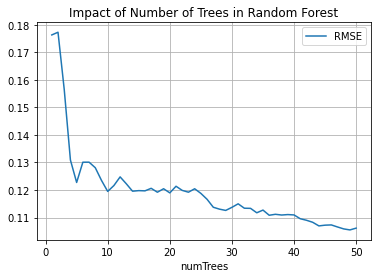

In [34]:
numTrees = ee.List.sequence(1, 50, 1)


def trees(t):
    rfRegression = ee.Classifier.smileRandomForest(numberOfTrees=t, seed=0).setOutputMode('REGRESSION').train(
    features= training, 
    classProperty= 'SM', 
    inputProperties= predictionBands)
    
    rfRegressionTesting = testing.classify(rfRegression, 'y_hat')

    # // Calculate the RMSE for RF regression and print the result
    regression=rfRegressionTesting.map(set_sqError)
    regression = ee.FeatureCollection(regression)
    MSE = regression.reduceColumns(ee.Reducer.mean(),['sqError'])
    RMSE =  ee.Number(MSE.get('mean')).sqrt()        
    return RMSE


rmse_trees=numTrees.map(trees)
value_info = rmse_trees.getInfo()

# Extracting tree value for minimum RMSE
min_rmse=min(value_info)
print("Min RMSE =", min_rmse)

index=value_info.index(min(value_info))
trees_range = numTrees.getInfo()
min_trees =trees_range[index]
print("Min Trees =", min_trees)

# print(rmse_gama.getInfo())

# Plotting the interations

import pandas as pd
df =pd.DataFrame(value_info,columns=['RMSE'])
df['numTrees'] = numTrees.getInfo() 

ax =df.plot.line(x='numTrees', 
             y='RMSE',
             title= 'Impact of Number of Trees in Random Forest'
             )
ax.grid()

same for svr

Min RMSE = 0.1291954689397015
Min Gamma = 0.1


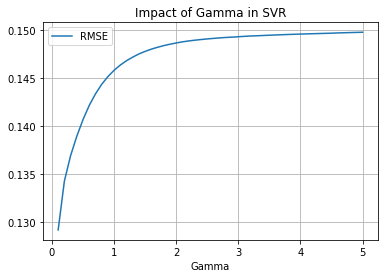

In [35]:
gamma_vals = ee.List.sequence(0.1, 5, 0.1)


def gammas(t):
    svrRegression = ee.Classifier.libsvm(svmType ='EPSILON_SVR',kernelType='RBF',gamma=t,cost=100).setOutputMode('REGRESSION').train(
      features= training, 
      classProperty= 'SM', 
      inputProperties= predictionBands
    )
    
    svrRegressionTesting = testing.classify(svrRegression, 'y_hat');

    # // Calculate the RMSE for SVM regression and print the result
    regression=svrRegressionTesting.map(set_sqError)
    regression = ee.FeatureCollection(regression)
    MSE = regression.reduceColumns(ee.Reducer.mean(),['sqError'])
    RMSE =  ee.Number(MSE.get('mean')).sqrt()        
    return RMSE


rmse_gama=gamma_vals.map(gammas)
value_info = rmse_gama.getInfo()

# Extracting gamma value for minimum RMSE
min_rmse=min(value_info)
print("Min RMSE =", min_rmse)

index=value_info.index(min(value_info))
gamma_range = gamma_vals.getInfo()
min_gamma =gamma_range[index]
print("Min Gamma =", min_gamma)

# print(rmse_gama.getInfo())

# Plotting the interations
import pandas as pd
df =pd.DataFrame(value_info,columns=['RMSE'])
df['Gamma'] = gamma_vals.getInfo() 

ax =df.plot.line(x='Gamma', 
             y='RMSE',
             title= 'Impact of Gamma in SVR'
             )
ax.grid()

same for cart regression

Min RMSE = 0.13378315557666212
Min Leaf = 16


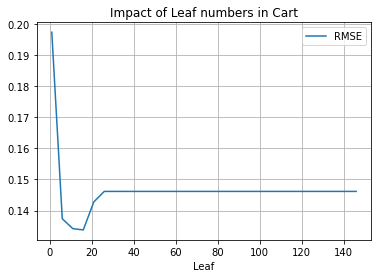

In [36]:
leaf_vals = ee.List.sequence(1, 150, 5)

def leafs(t):
    cartRegression = ee.Classifier.smileCart(minLeafPopulation=t).setOutputMode('REGRESSION').train(
    features= training, 
    classProperty= 'SM', 
    inputProperties= predictionBands
    )

    cartRegressionTesting = testing.classify(cartRegression, 'y_hat');

    # // Calculate the RMSE for CART regression and print the result
    regression=cartRegressionTesting.map(set_sqError)
    regression = ee.FeatureCollection(regression)
    MSE = regression.reduceColumns(ee.Reducer.mean(),['sqError'])
    RMSE =  ee.Number(MSE.get('mean')).sqrt()        
    return RMSE


rmse_leaf=leaf_vals.map(leafs)
value_info = rmse_leaf.getInfo()

# Extracting gamma value for minimum RMSE
min_rmse=min(value_info)
print("Min RMSE =", min_rmse)

index=value_info.index(min(value_info))
leaf_range = leaf_vals.getInfo()
min_leaf =leaf_range[index]
print("Min Leaf =", min_leaf)

# print(rmse_gama.getInfo())

# Plotting the interations
import pandas as pd
df =pd.DataFrame(value_info,columns=['RMSE'])
df['Leaf'] = leaf_vals.getInfo() 

ax =df.plot.line(x='Leaf', 
             y='RMSE',
             title= 'Impact of Leaf numbers in Cart'
             )
ax.grid()